In [1]:
# initial imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt, log1p

In [2]:
# Read in data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

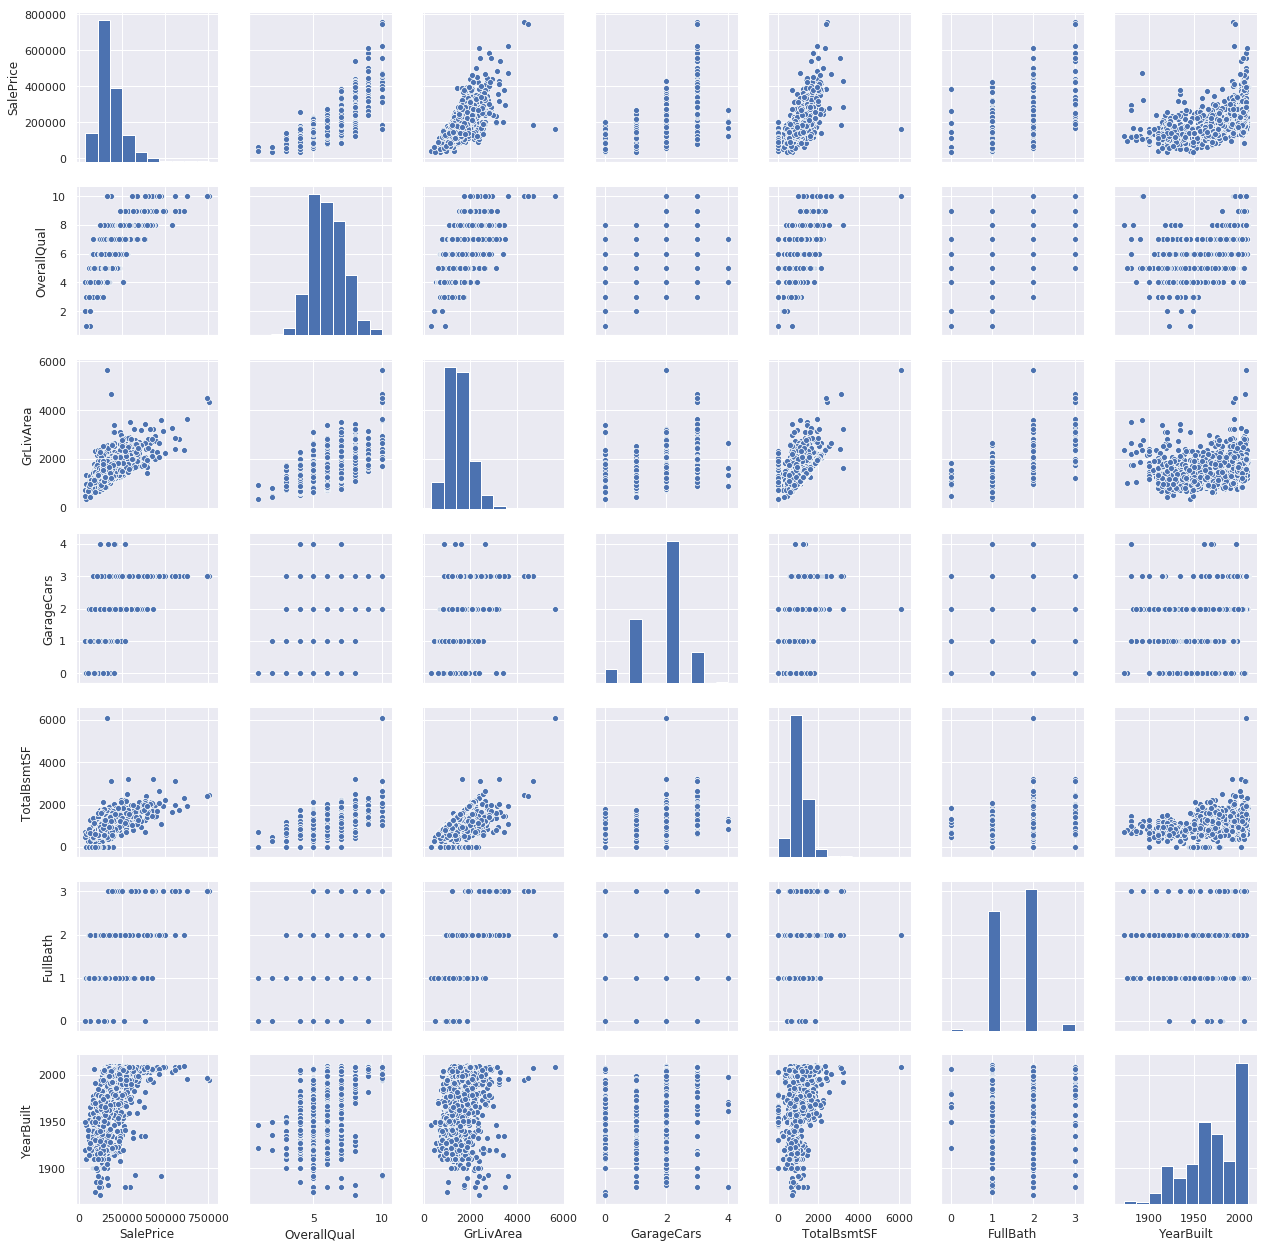

In [4]:
# Initial visualisations to identify outliers
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

In [3]:
# Removing outliers
train = train.drop(train[(train['GrLivArea']>4500)].index)
train = train.drop(train[(train['TotalBsmtSF']>=4000)].index)

In [5]:
ntrain = train.shape[0]
ntest = test.shape[0]
# Get target vector
y_train = train.SalePrice.values
# Creating a consolidated dataframe
data = pd.concat((train, test)).reset_index(drop=True)
data.drop(['SalePrice'], axis=1, inplace=True)
print("Concatenated data size is : {}".format(data.shape))

Concatenated data size is : (2919, 80)


In [6]:
## DEALING WITH MISSING VALUES ##

# Replacing missing value with None for appropiate columns acc to data description
data["PoolQC"] = data["PoolQC"].fillna("None")
data["MiscFeature"] = data["MiscFeature"].fillna("None")
data["Alley"] = data["Alley"].fillna("None")
data["Fence"] = data["Fence"].fillna("None")
data["FireplaceQu"] = data["FireplaceQu"].fillna("None")
data["MasVnrType"] = data["MasVnrType"].fillna("None")
data['MSSubClass'] = data['MSSubClass'].fillna("None")
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    data[col] = data[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[col] = data[col].fillna('None')
    
# Replacing missing value with 0 for appropiate columns acc to data description
for col in ('GarageYrBlt', 'GarageCars'):
    data[col] = data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    data[col] = data[col].fillna(0)
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)

data["LotFrontage"] = data["LotFrontage"].fillna(data['LotFrontage'].mean())
data["GarageArea"] = data["GarageArea"].fillna(data['GarageArea'].mean())

# Replacing missing value with most common value for appropiate columns acc to data description
data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].mode()[0])
for col in ['Electrical','KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']:
    data[col] = data[col].fillna(data[col].mode()[0])
data["Functional"] = data["Functional"].fillna("Typ")

# Dropping column
data = data.drop(['Utilities'], axis=1)

In [8]:
# Select columns that we came up with as a team to model with
# For further clarification look at the R code.
selected_cols = ['OverallQual','GrLivArea','GarageCars','GarageArea',
                 'TotalBsmtSF','1stFlrSF','BsmtFinSF1','2ndFlrSF','YearBuilt']
data = data[selected_cols]
data.shape

(2919, 9)

In [9]:
# Number of folds for k-fold validation
n_folds = 5
# Defining a function to calculate RMSLE
def knn_rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [11]:
# Importing package for preprocessing data
from sklearn import preprocessing
col_names = data.columns
x = data.values
# Performing column wise normalization
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data_scaled = pd.DataFrame(x_scaled)
data_scaled.shape

(2919, 9)

In [13]:
# Implementing the KNN Regression algorithm
def knnRegression(X_train, y_train, X_test, k, p, distance_type):
    # Lists to store different distance metrics
    euc_dist = []
    preds_euc = []
    preds_man = []
    # Initializing list to hold predictions
    preds = []
    # Iterate over the test set
    for tst_idx, tst_val in X_test.iterrows():
        # Calculate eucledian distance
        euc_dists = np.sqrt(np.sum(np.power((np.array(X_train) - np.array(tst_val)), 2), axis=1))
        # Calculate manhattan distance
        man_dists = np.sum(abs(np.array(X_train) - np.array(tst_val)), axis=1)
        # Replacing zero distance values with 0.0001 to prevent 1/0 error
        euc_dists[euc_dists == 0] = 0.0001
        man_dists[man_dists == 0] = 0.0001
        # Using the distance specified in the function call
        if distance_type == 'm':
            nearest_data_point_dists = np.sort(man_dists)[:k]
            nearest_data_point_index = np.argsort(man_dists)[:k]
        else:
            nearest_data_point_dists = np.sort(euc_dists)[:k]
            nearest_data_point_index = np.argsort(euc_dists)[:k]
        # Calculate weights using inverse distance weighting (Ref: The shephard's method)
        dist_weights = np.power((1. / nearest_data_point_dists), p) / np.sum(np.power((1. / nearest_data_point_dists), p))
        pred = 0
        # Iterate over the nearest k points to find the average
        for index, point_index in enumerate(nearest_data_point_index):
            # Taking weighted mean of saleprices of nearest points using computed weights
            pred = pred + dist_weights[index]*y_train[point_index]
        preds.append(pred)
    return preds

In [14]:
knn_acc = []
knn_acc_2 = []

# Spliting into train-validation set
X_train, X_test, y_train, y_test = train_test_split(data_scaled[:ntrain], train.SalePrice.values, test_size=0.2)

# Judging the model accuracy with different hyperparameters
for k in range(2, 16):
    knn_acc_1 = []
    for p in range(1, 2):
        for t in ['m', 'n']:
            knn_preds = knnRegression(X_train, y_train, X_test, k, p, t)
            knn_preds = np.array(knn_preds)
            knn_acc.append(sqrt(mean_squared_error(np.log(y_test), np.log(knn_preds))))

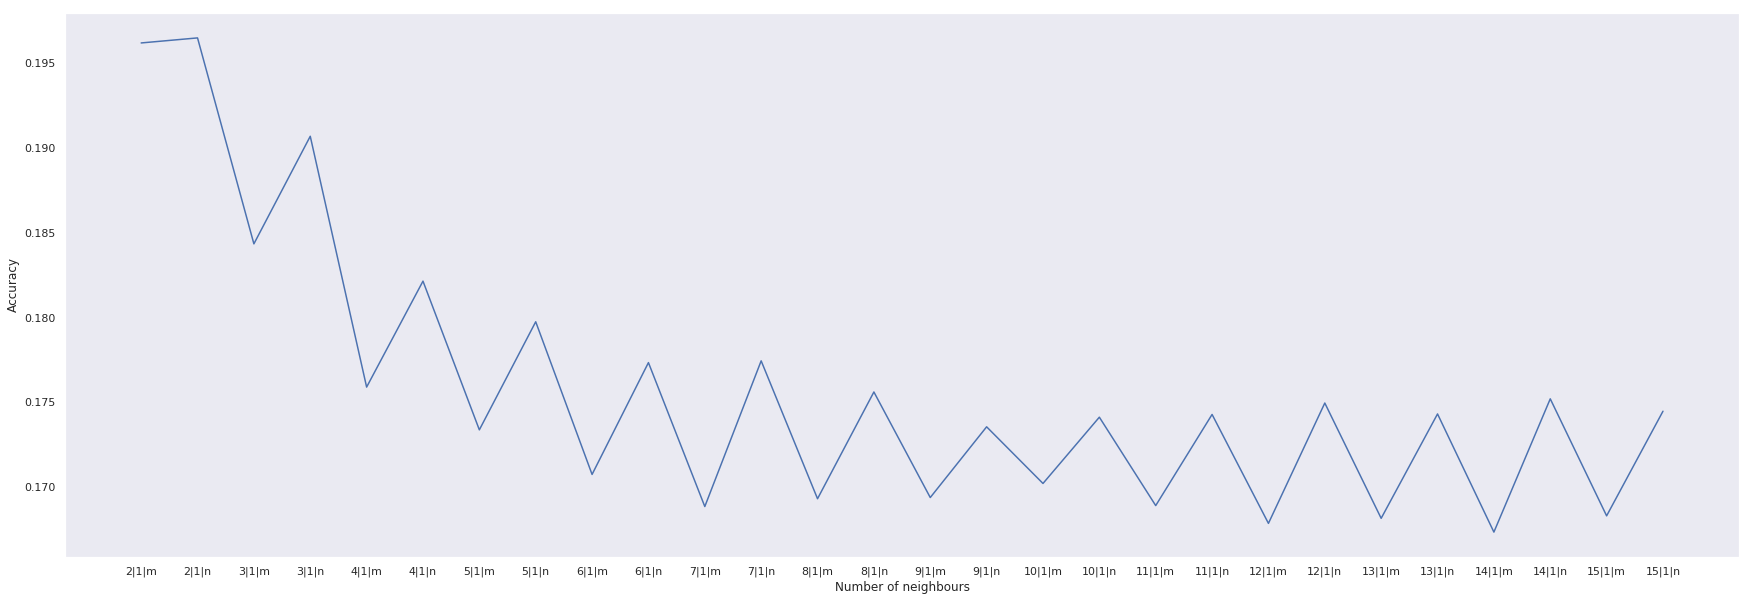

In [15]:
# Plotting all the accuracies to select the hyperparameters
ind = []
for i in range(2, 16):
    for p in range(1, 2):
        for t in ['m', 'n']:
            ind.append(str(i) + '|' + str(p)+ '|' + t)

plt.figure(figsize=(30,10))
plt.plot(ind, knn_acc)
plt.xlabel('Number of neighbours')
plt.ylabel('Accuracy')

plt.grid()
plt.show()

In [16]:
# Splitting data to train and test for the final predictions. 
X_train = data_scaled[:ntrain]
y_train = train.SalePrice.values
X_test = data_scaled[ntrain:]
# Making predictions
preds = knnRegression(X_train, y_train, X_test, 9, 1, 'm')

In [15]:
# Writing predictions to file
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("knnInvManDistk9p1.csv", index = False)